- Jennifer Patricia
- 113703105

*I decided to pursue text classification specifically in the medical domain, as I’ve previously conducted numerous topic modeling projects on social media data. While it remains within the broader field of NLP, this shift allows me to explore a new area, deepen my expertise, and expand my portfolio with more diverse and impactful applications.*

- **ABOUT DATASET**
- link source: https://www.kaggle.com/datasets/chaitanyakck/medical-text/data?select=train.dat
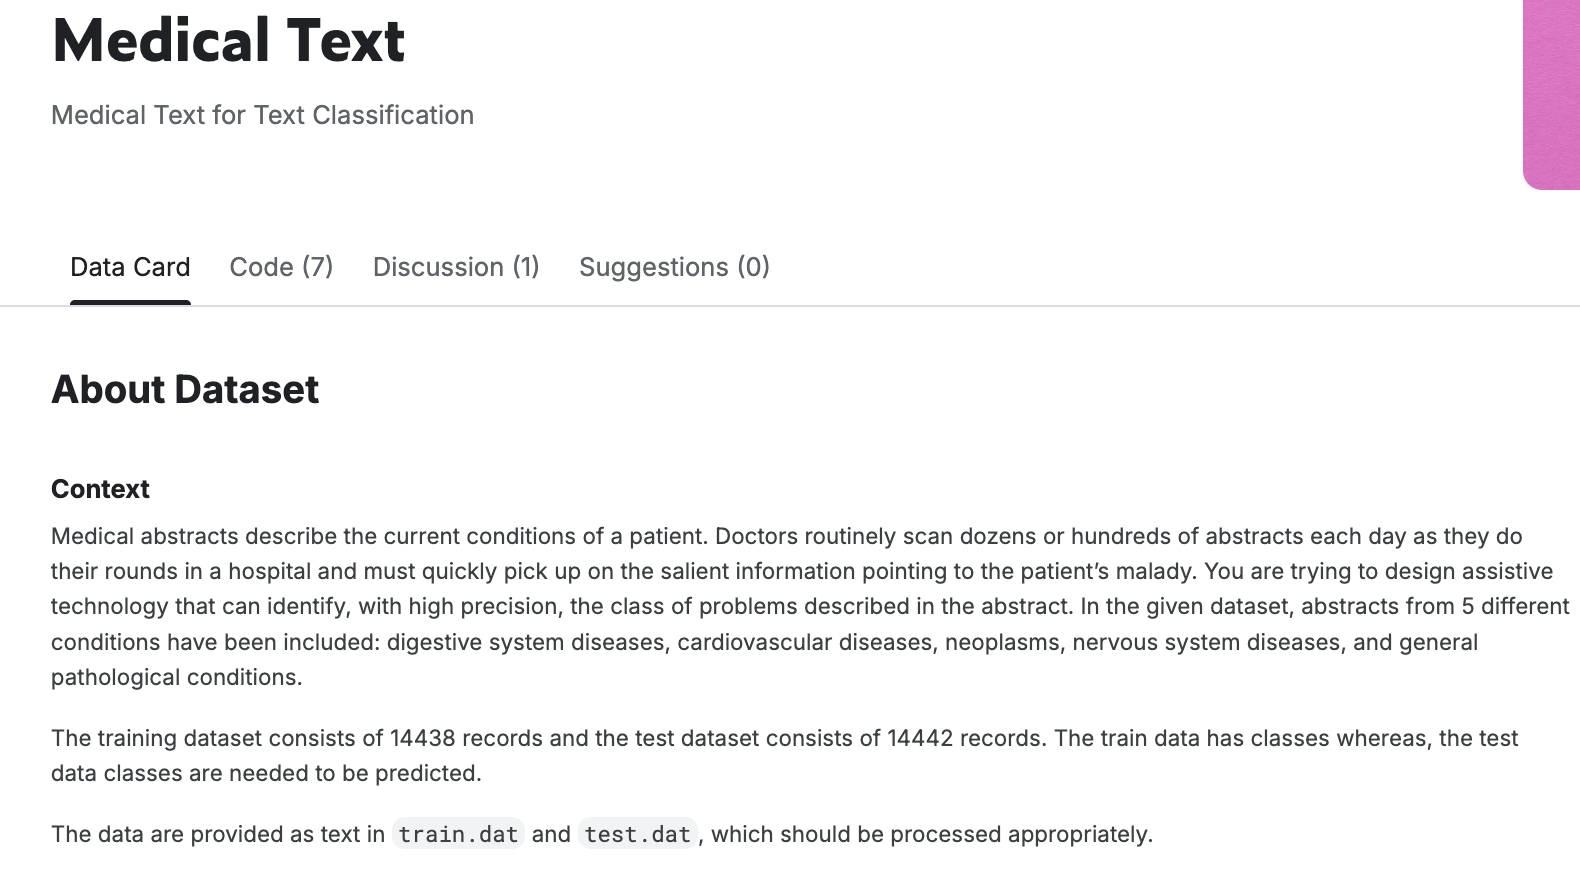

**NOTES**: 
1. Digestive System Diseases
   - Diseases affecting the gastrointestinal tract, including the stomach, intestines, liver, and pancreas.
2. Cardiovascular Diseases
   - Disorders related to the heart and blood vessels, such as hypertension and heart attacks.
3. Neoplasms
   - Abnormal growths of tissue, including both benign tumors and cancers.
4. Nervous System Diseases
   - Conditions that affect the brain, spinal cord, and nerves, including neurodegenerative and neurological disorders.
5. General Pathological Conditions
   - Broad or systemic abnormalities that don't fit into a single organ system, such as inflammation, infections, or autoimmune conditions.

In [69]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df_train = pd.read_csv("/kaggle/input/medical-text/train.dat", sep="\t", header=None)
df_test = pd.read_csv("/kaggle/input/medical-text/test.dat", sep="\t", header=None)
df_train.head()

,0,1
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...


In [6]:
df_train.columns = ["labels", "text"]
df_test.columns = ["text"]

In [96]:
df_train["labels"].value_counts()

labels
5    4805
1    3163
4    3051
3    1925
2    1494
Name: count, dtype: int64

In [7]:
print(df_train.shape)
print(df_test.shape)

(14438, 2)
(14442, 1)


In [8]:
x_train, x_val, y_train, y_val = train_test_split(df_train["text"], df_train["labels"], test_size=0.1, random_state=9, stratify=df_train["labels"])

In [9]:
print(len(x_train))
print(len(x_val))

12994
1444


# Data Cleaning

In [73]:
for i, text in enumerate(df_train[:10]["text"]):
    words = text.lower().split()
    short_words = [w for w in words if len(w) <= 3 and w.isalpha() and w not in stop_words]
    print(f"Row {i}: {short_words}")

Row 0: ['age', 'six', 'p', 'one']
Row 1: ['ten']
Row 2: ['one']
Row 3: ['use', 'far', 'one']
Row 4: ['led', 'min', 'mm', 'mm', 'kcl', 'mm', 'hr', 'min', 'air', 'may']
Row 5: ['use', 'use', 'ill']
Row 6: ['one']
Row 7: ['one']
Row 8: []
Row 9: ['new', 'new']


**NOTES**: Most of the 3-character words are units, typos, or irrelevant terms (e.g., "mm", "kcl", "hr", "p", "one"), so we decided to remove them to clean the data further.

In [74]:
def preprocess(text):
    text = text.replace('\n', ' ').replace('\t', ' ')
    text = re.sub(r'\s+', ' ', text)                 # remove extra whitespaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)          # remove all non-letters (punctuations + numbers)
    text = text.strip().lower()

    # Tokenize, remove stopwords, short words, and re-join
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words and len(word) > 3]
    return ' '.join(filtered_words)

In [75]:
x_train_clean = []
y_train_clean = [] 
for index in tqdm(range(len(x_train)), desc="Processing texts"):
    try:
        processed_text = preprocess(x_train.iloc[index])
        x_train_clean.append(processed_text)
        y_train_clean.append(y_train.iloc[index]) 
    except IndexError:
        continue  

Processing texts: 100%|██████████| 12994/12994 [00:01<00:00, 7962.67it/s]


In [76]:
x_val_clean = []
y_val_clean = [] 
for index in tqdm(range(len(x_val)), desc="Processing texts"):
    try:
        processed_text = preprocess(x_val.iloc[index])
        x_val_clean.append(processed_text)
        y_val_clean.append(y_val.iloc[index]) 
    except IndexError:
        continue  

Processing texts: 100%|██████████| 1444/1444 [00:00<00:00, 8318.42it/s]


In [77]:
x_test_clean = []
for index in tqdm(range(len(df_test)), desc="Processing texts"):
    try:
        processed_text = preprocess(df_test["text"].iloc[index])
        x_test_clean.append(processed_text)
    except IndexError:
        continue  

Processing texts: 100%|██████████| 14442/14442 [00:01<00:00, 8038.53it/s]


In [78]:
x_train_clean[1]

'enterogenous cyst cerebellopontine angle cistern case report case enterogenous cyst located cerebellopontine angle cistern presented cysts usually found spinal canal intracranial occurrence exceptional present case cyst lined histologically single epithelial layer cuboidal cells glandular structures resembling fundic glands stomach unusual location cyst histological features discussed'

In [79]:
df_train_cleaned = pd.DataFrame({
    "text": x_train_clean,
    "labels": y_train_clean
})

df_val_cleaned = pd.DataFrame({
    "text": x_val_clean,
    "labels": y_val_clean
})

In [80]:
print(df_train_cleaned["labels"].unique())
print(df_train_cleaned["labels"].dtype)

[4 3 5 1 2]
int64


**NOTES**: Most classification models (especially in PyTorch, HuggingFace, Sklearn, TensorFlow, etc.) require labels to be zero-based and consecutive — so each label is reduced by 1.

In [81]:
df_train_cleaned["labels"] = df_train_cleaned["labels"].astype(int) - 1
df_val_cleaned["labels"] = df_val_cleaned["labels"].astype(int) - 1
print(df_train_cleaned["labels"].unique())

[3 2 4 0 1]


In [82]:
df_train_cleaned

,text,labels
0,high blood cholesterol elderly excess risk cor...,3
1,enterogenous cyst cerebellopontine angle ciste...,2
2,cytomegalovirus neuropathy acquired immunodefi...,4
3,amenorrhea amenorrhea lack menstruation gyneco...,4
4,squamous carcinoma distal esophagus survival s...,0
...,...,...
12989,analysis baroreflex control heart rate conscio...,3
12990,hormonalmetabolic stress responses neonates un...,4
12991,signetring cell carcinoma ampulla vater descri...,0
12992,vegetables fruits carotenoids risk cancer inta...,0


# Data Preparation

We use "dmis-lab/biobert-base-cased-v1.1" as our pretrained model. This model is specifically trained on biomedical texts (PubMed and PMC), making it well-suited for healthcare-related classification tasks. It's lighter than large LLMs like LLaMA or GPT, so it saves time and GPU memory, while still achieving strong performance in domain-specific tasks.

In [18]:
model_name = "dmis-lab/biobert-base-cased-v1.1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
def convert_to_dataset(df):
    return Dataset.from_pandas(df)

train_dataset = convert_to_dataset(df_train_cleaned)
val_dataset = convert_to_dataset(df_val_cleaned)
test_dataset = convert_to_dataset(df_test)

In [84]:
def preprocess_data(example, tokenizer, max_input_length=128):
    tokenized_input = tokenizer(
        example["text"],
        truncation=True,
        padding='max_length',
        max_length=max_input_length
    )
    
    if "label" in example:
        tokenized_input["label"] = example["label"]
    
    return tokenized_input

In [85]:
train_dataset = train_dataset.map(lambda x: preprocess_data(x, tokenizer), batched=True)
val_dataset = val_dataset.map(lambda x: preprocess_data(x, tokenizer), batched=True)
test_dataset = test_dataset.map(lambda x: preprocess_data(x, tokenizer), batched=True)

Map:   0%|          | 0/12994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1444 [00:00<?, ? examples/s]

Map:   0%|          | 0/14442 [00:00<?, ? examples/s]

In [86]:
print(train_dataset.features)

{'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [56]:
print("Unique labels in training:", sorted(set(train_dataset['labels'])))
print("num_labels in model:", model.config.num_labels)
print(train_dataset[0]["labels"])
print(type(train_dataset[0]["labels"]))

Unique labels in training: [0, 1, 2, 3, 4]
num_labels in model: 5
3
<class 'int'>


# Building Models

# SUPERVISED MODEL

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}
    
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    report_to="none",
    load_best_model_at_end=True,
    disable_tqdm=False,
    metric_for_best_model="accuracy",
    greater_is_better=False 
)


trainer = Trainer(
    model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] ,
)

In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.908400,0.767375,0.675927
2,0.666400,0.646612,0.714176
3,0.894600,0.591816,0.736494
4,0.530700,0.515181,0.752501
5,0.395200,0.449922,0.766431
6,0.532800,0.418721,0.774665
7,0.496500,0.374968,0.780976
8,0.645000,0.339435,0.789056
9,0.356000,0.327100,0.790519
10,0.369500,0.320059,0.794136


TrainOutput(global_step=16250, training_loss=0.5694363016862136, metrics={'train_runtime': 2622.6349, 'train_samples_per_second': 49.546, 'train_steps_per_second': 6.196, 'total_flos': 8547392857943040.0, 'train_loss': 0.5694363016862136, 'epoch': 10.0})

In [32]:
predictions = trainer.predict(val_dataset)  # or test_dataset

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print(classification_report(labels, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9280    0.7699    0.8416      2847
           1     0.7031    0.8275    0.7602      1345
           2     0.8067    0.7327    0.7679      1732
           3     0.8432    0.7932    0.8174      2746
           4     0.7290    0.8249    0.7740      4324

    accuracy                         0.7941     12994
   macro avg     0.8020    0.7896    0.7922     12994
weighted avg     0.8044    0.7941    0.7958     12994



**NOTES**: The classification report shows a balanced and solid performance across all five labels, with an overall accuracy of 79.4% and strong macro and weighted F1-scores around 0.79. The model handles both majority and minority classes reasonably well, indicating that it generalizes well despite the class imbalance. However, accuracy could potentially be enhanced further by addressing the imbalance more directly through data augmentation, class-specific sampling, or advanced loss functions like focal loss or label smoothing. These techniques could help the model better capture underrepresented classes and improve overall robustness.

In [37]:
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
labels[:5]

array([3, 2, 4, 4, 0])

In [39]:
df_val_cleaned.head()

,text,labels
0,high blood cholesterol elderly men excess risk...,3
1,enterogenous cyst cerebellopontine angle ciste...,2
2,cytomegalovirus neuropathy acquired immunodefi...,4
3,"amenorrhea. amenorrhea, lack menstruation, gyn...",4
4,squamous carcinoma distal esophagus survival s...,0


**CONCLUSION**: the predicted output is accurate

# UNSUPERVISED MODELS

# 1. LDA (Latent Dirichlet Allocation)
- Tries to find patterns in word distributions across documents
- Aims to infer "hidden topics" (latent topics) within the document collection


- LDA Assumes:
    - Each document is a mixture of multiple topics
    - Each topic is a collection of words with a certain probability distribution



## a. LDA w TF-IDF

In [57]:
df_train_cleaned = df_train.copy()
df_train_cleaned["text"] = df_train_cleaned["text"].apply(preprocess)

In [59]:
v = TfidfVectorizer()
v.fit(df_train_cleaned["text"])
tdf_array = v.fit_transform(df_train_cleaned["text"]).toarray() 
tdf_array[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Top 10 words for Topic #0:
['coronary', 'patients', 'artery', 'left', 'ventricular', 'valve', 'aortic', 'angioplasty', 'flow', 'mitral']
Top 10 words for Topic #1:
['hypertensive', 'angiotensin', 'pressure', 'renin', 'rats', 'captopril', 'blood', 'hypertension', 'ace', 'calcium']
Top 10 words for Topic #2:
['patients', 'case', 'patient', 'cases', 'report', 'syndrome', 'disease', 'year', 'one', 'nerve']
Top 10 words for Topic #3:
['patients', 'disease', 'treatment', 'group', 'cancer', 'less', 'risk', 'study', 'therapy', 'clinical']
Top 10 words for Topic #4:
['cells', 'cell', 'dna', 'human', 'gene', 'expression', 'tumor', 'virus', 'hepatitis', 'leukemia']


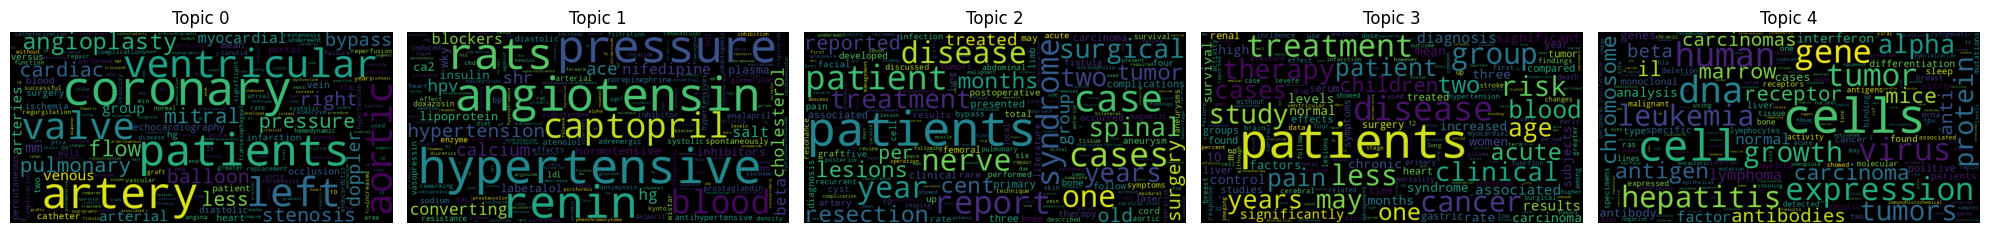

In [60]:
lda = LatentDirichletAllocation(n_components=5, random_state=42) #Choosing 5 as the num of total labels
lda.fit(tdf_array)

n_top_words = 10
feature_names = v.get_feature_names_out() 

for topic_idx, topic in enumerate(lda.components_):
    print(f"Top 10 words for Topic #{topic_idx}:")
    print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

fig, ax = plt.subplots(1, 5, figsize=(20, 15))
for i, topic in enumerate(lda.components_):
    wc = WordCloud(width=800, height=400, max_font_size=100).generate_from_frequencies(dict(zip(feature_names, topic)))
    ax[i].imshow(wc)
    ax[i].axis("off")
    ax[i].set_title(f"Topic {i}")

plt.tight_layout()
plt.show()

**EXPLANATION**:

**1. 🟦 Topic 0: Cardiovascular / Heart Disease**
* Top Words ['coronary', 'patients', 'artery', 'left', 'ventricular', 'valve', 'aortic', 'angioplasty', 'flow', 'mitral']
- This is clearly a cardiology-focused topic:
   - "coronary", "artery", "valve", "angioplasty" → heart procedures
   - "left ventricular", "aortic", "flow" → anatomy and cardiac function
- Highly specific — deals with heart conditions and interventions

Absolutely bro! Here's the **rewritten version** of topics 2 to 5 so they match the clean, structured style of Topic 1:

---

**2. 🟩 Topic 1: Hypertension / Blood Pressure Regulation**

* Top Words: \['hypertensive', 'angiotensin', 'pressure', 'renin', 'rats', 'captopril', 'blood', 'hypertension', 'ace', 'calcium']

- This topic clearly relates to hypertension and blood pressure control:
  * "angiotensin", "renin", "captopril", "ace" → components of the RAAS system (Renin-Angiotensin-Aldosterone)
  * "hypertension", "pressure", "blood" → indicators of cardiovascular regulation
- Also references animal testing: "rats"
- Highly relevant for pharmacological research on blood pressure and cardiovascular function

---

**3. 🟨 Topic 2: Case Reports / Neurological Syndromes**

* Top Words: \['patients', 'case', 'patient', 'cases', 'report', 'syndrome', 'disease', 'year', 'one', 'nerve']

- This topic focuses on clinical observations and individual reports:
  * "patients", "case", "cases", "report" → strongly indicative of case-based medical documentation
  * "syndrome", "nerve" → likely involves neurology or rare clinical conditions
- A somewhat mixed theme, but clearly centered on narrative clinical reporting
- Represents descriptions of unique or rare medical cases

---

**4. 🟥 Topic 3: Cancer, Therapy & Clinical Studies**

* Top Words: \['patients', 'disease', 'treatment', 'group', 'cancer', 'less', 'risk', 'study', 'therapy', 'clinical']

- This topic emphasizes clinical oncology and treatment evaluation:
  * "cancer", "therapy", "treatment", "clinical" → direct association with cancer care
  * "risk", "study", "group" → common in clinical trials or epidemiological research
- Captures the structure of experimental medical studies
- Highly relevant for cancer treatment and evidence-based medicine

---

**5. 🟪 Topic 4: Genetics / Molecular Biology / Immunology**

* Top Words: \['cells', 'cell', 'dna', 'human', 'gene', 'expression', 'tumor', 'virus', 'hepatitis', 'leukemia']

- This topic delves into molecular-level mechanisms of disease:
  * "gene", "expression", "dna" → fundamental elements of molecular biology
  * "tumor", "leukemia", "virus", "hepatitis" → related to cancer and infectious disease origins
- Suggests a strong focus on genetics and immunopathology
- Highly applicable to cancer biology, virology, and gene-level diagnostics

---
**CONCLUSION**:

The topic modeling results are quite solid, as the LDA successfully grouped the abstracts into medically meaningful categories, with each topic aligning well with distinct clinical domains.
